In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score

import seaborn as sns

# Juntandos os dados em um único DataFrame

In [2]:
def get_data_gathered(cities: list[str] = ['cleveland'], save: bool = False) -> pd.DataFrame:
    columns = [
        'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'
    ]

    def load_data(file_path: str) -> pd.DataFrame:
        df = pd.read_csv(file_path, header=None, names=columns, na_values='?')
        return df

    files: list[str] = [f'./data/processed.{city}.data' for city in cities]

    result_df = pd.concat([load_data(file)
                          for file in files], ignore_index=True)
    if save:

        output_path = f'./data/heart_disease_{"_".join(cities)}.csv'
        result_df.to_csv(output_path, index=False)
        print(f"Arquivo CSV criado com sucesso em: {output_path}")

    return result_df

# Pré processamento dos dados

Foram implementadas 2 alternativas para teste, uma em que os valores nulos são preenchidos, e outra em que os valores nulos são removidos.

In [3]:
def deal_with_nil(original_df: pd.DataFrame, drop_nulls: bool = True) -> pd.DataFrame:
    if drop_nulls:
        return original_df.dropna()

    df = original_df.copy()
    # Substitua lacunas para frente do valor válido anterior em: 'trestbps'
    df = df.fillna({'trestbps': df['trestbps'].ffill()})
    # Substitua os valores ausentes pela média de cada coluna em: 'chol'
    df = df.fillna({'chol': df['chol'].mean()})
    # Substitua as lacunas do próximo valor válido em: 'fbs'
    df = df.fillna({'fbs': df['fbs'].bfill()})
    # Substitua os valores ausentes pela média de cada coluna em: 'thalach'
    df = df.fillna({'thalach': df['thalach'].mean()})
    # Substitua os valores ausentes pelo modo de cada coluna em: 'restecg'
    df = df.fillna({'restecg': df['restecg'].mode()[0]})
    # Substitua os valores ausentes pelo modo de cada coluna em: 'exang'
    df = df.fillna({'exang': df['exang'].mode()[0]})
    # Remover coluna: 'ca' (muitos nulls)
    df = df.drop(columns=['ca'])
    # Substitua lacunas para frente do valor válido anterior em: 'slope'
    df = df.fillna({'slope': df['slope'].ffill()})
    # Substitua os valores ausentes pelo modo de cada coluna em: 'thal'
    df = df.fillna({'thal': df['thal'].mode()[0]})
    # Substitua lacunas para frente do valor válido anterior em: 'oldpeak'
    df = df.fillna({'oldpeak': df['oldpeak'].ffill()})
    return df

Para a normalização foi usado o MinMaxScaler, que transforma os dados para que fiquem entre 0 e 1. Transformando a coluna objetivo em 0 e 1. Onde 0 é saudável e 1 é doente, no banco de dados original os valores são [0..4], onde qualquer número >0 é não saudável.

In [4]:
def normalize(original_df: pd.DataFrame) -> pd.DataFrame:
    df_clean = original_df.copy()
    print("Quantidade de classes nos dados limpos:")
    print(df_clean['num'].value_counts())

    df_clean['num'] = df_clean['num'].apply(
        lambda x: 0 if x == 0 else 1)

    scaler = MinMaxScaler()
    df_clean_normalized = df_clean.copy()
    df_clean_normalized = pd.DataFrame(scaler.fit_transform(
        df_clean_normalized), columns=df_clean_normalized.columns)

    df_clean_normalized.describe()

    df_clean_normalized['num'] = df_clean_normalized['num'].astype(bool)

    print("Quantidade de classes nos dados normalizados:")
    print(df_clean_normalized['num'].value_counts())

    return df_clean_normalized

In [5]:
df: pd.DataFrame = normalize(deal_with_nil(get_data_gathered()))

Quantidade de classes nos dados limpos:
num
0    160
1     54
2     35
3     35
4     13
Name: count, dtype: int64
Quantidade de classes nos dados normalizados:
num
False    160
True     137
Name: count, dtype: int64


# Replicando a arquitetura do artigo

In [6]:
X = df.drop('num', axis=1)
y = df['num']

## Dividindo em treino e teste 60:40
Foi feito assim como no artigo

In [7]:
model_60_40 = MLPClassifier(hidden_layer_sizes=(
    6,), max_iter=2000, learning_rate_init=0.32, momentum=0.72)

# Divide o dataset em 60% treino e 40% teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42)

# Exibe os tamanhos dos conjuntos de treino e teste
print(f'Tamanho do conjunto de treino: {X_train.shape[0]}')
print(f'Tamanho do conjunto de teste: {X_test.shape[0]}')

Tamanho do conjunto de treino: 178
Tamanho do conjunto de teste: 119


## Treinamento do modelo

Matriz de Confusão:
[[18  3]
 [ 1  7]]
Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.95      0.86      0.90        21
        True       0.70      0.88      0.78         8

    accuracy                           0.86        29
   macro avg       0.82      0.87      0.84        29
weighted avg       0.88      0.86      0.87        29



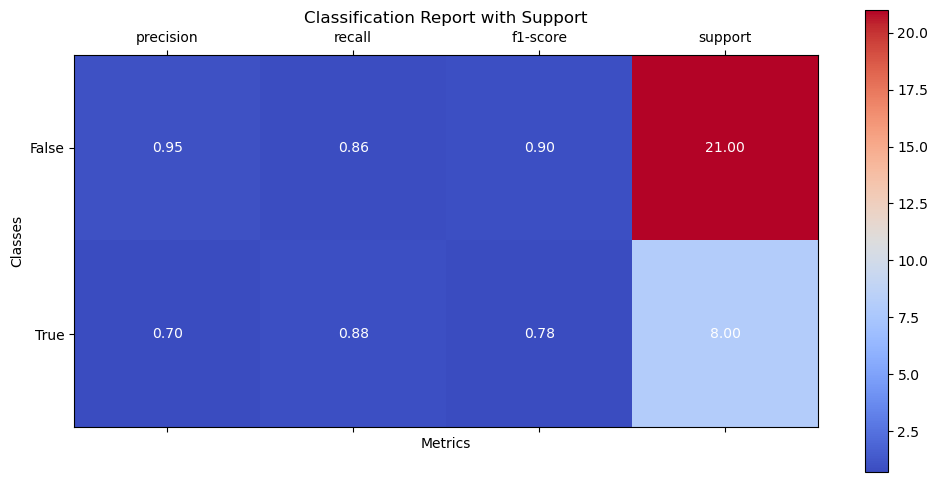

F1-Score: 0.7777777777777778
Score: 0.8620689655172413


In [98]:
model_60_40.fit(X_train, y_train)
score = model_60_40.score(X_test, y_test)

y_pred = model_60_40.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
print('Matriz de Confusão:')
print(conf_matrix)

cr = classification_report(y_test, y_pred)
print('Relatório de Classificação:')
print(cr)


def plot_classification_report_with_support(report):
    # Exclude 'accuracy', 'macro avg', 'weighted avg'
    labels = list(report.keys())[:-3]
    metrics = ['precision', 'recall', 'f1-score', 'support']
    data = np.array([[report[label][metric]
                    for metric in metrics] for label in labels])
    fig, ax = plt.subplots(figsize=(12, 6))
    cax = ax.matshow(data, cmap='coolwarm')
    plt.xticks(range(len(metrics)), metrics)
    plt.yticks(range(len(labels)), labels)
    plt.colorbar(cax)
    # Adding the text
    for (i, j), val in np.ndenumerate(data):
        ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='white')
    plt.xlabel('Metrics')
    plt.ylabel('Classes')
    plt.title('Classification Report with Support')
    plt.show()


# Plotting the classification report with support
plot_classification_report_with_support(
    classification_report(y_test, y_pred, output_dict=True)
)
print(f'F1-Score: {f1_score(y_test, y_pred)}')
print(f"Score: {score}")

## Plotando a matriz de confusão

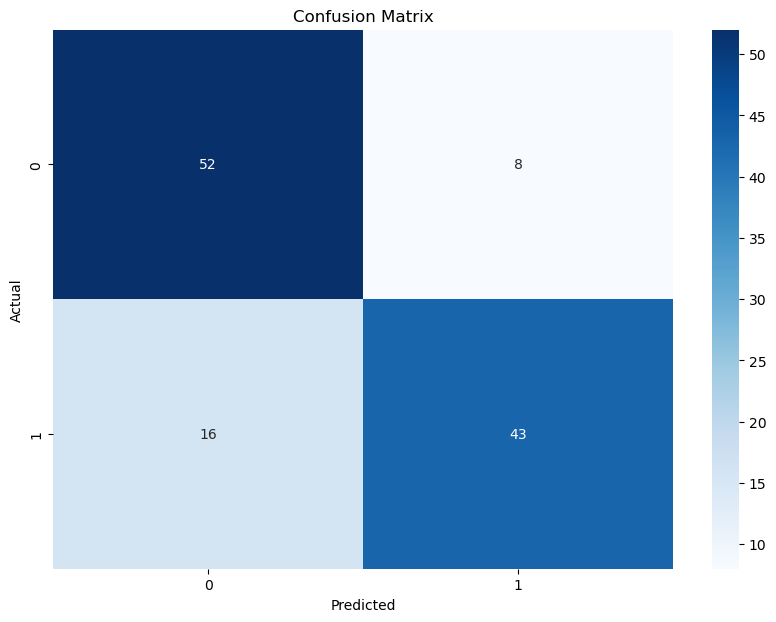

In [9]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Primeira modificação

Nesta modificação iremos usar **kfold** com [2..20] splits ao invés de dividir em 60:40

In [68]:
results = []
for splits in range(2, 21):
    splits = 5
    kf = KFold(n_splits=splits, shuffle=True)

    model_kfold = MLPClassifier(hidden_layer_sizes=(
        6,), max_iter=2000, learning_rate_init=0.32, momentum=0.72)

    count = 0
    scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        count += 1
        model_kfold.fit(X_train, y_train)
        score = model_kfold.score(X_test, y_test)
        scores.append(score)

    results.append(np.mean(scores))

In [69]:
for lr, scores in enumerate(results):
    print(f'{lr+2:02}:\t{scores:.4f}')

02:	0.8150
03:	0.8153
04:	0.7946
05:	0.8183
06:	0.7009
07:	0.7852
08:	0.8050
09:	0.7604
10:	0.8248


In [70]:
best_score = (0, 0)

for lr, scores in enumerate(results):
    if scores > best_score[1]:
        best_score = (lr+2, np.mean(scores))

print()
print(f'Melhor número de splits: {best_score[0]}')
print(f'Melhor score médio: {best_score[1]:.3f}')


Melhor número de splits: 10
Melhor score médio: 0.825


## Segunda modificação

Pegando o melhor numero de splits e alterando o learning rate

In [85]:
best_split_size = best_score[0]
kf = KFold(n_splits=best_split_size, shuffle=True)
results_lr: dict[float, np.float64] = {}
for lr in range(1, 101):
    model_kfold = MLPClassifier(hidden_layer_sizes=(
        6,), max_iter=2000, learning_rate_init=lr/100, momentum=0.72)

    count = 0
    scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        count += 1
        model_kfold.fit(X_train, y_train)
        score = model_kfold.score(X_test, y_test)
        scores.append(score)
    results_lr[lr/100] = np.mean(scores)

In [87]:
for lr, scores in results_lr.items():
    print(f'{lr}:\t{scores:.4f}')

best_score = (0.0, 0)

for lr, scores in results_lr.items():
    if scores > best_score[1]:
        best_score = (lr, np.mean(scores))

0.01:	0.8417
0.02:	0.8082
0.03:	0.8078
0.04:	0.8286
0.05:	0.7941
0.06:	0.8182
0.07:	0.7880
0.08:	0.8048
0.09:	0.7947
0.1:	0.7985
0.11:	0.8046
0.12:	0.7943
0.13:	0.8011
0.14:	0.7844
0.15:	0.8214
0.16:	0.7916
0.17:	0.8251
0.18:	0.7841
0.19:	0.7405
0.2:	0.8007
0.21:	0.8152
0.22:	0.8220
0.23:	0.8111
0.24:	0.7879
0.25:	0.8254
0.26:	0.8218
0.27:	0.8084
0.28:	0.8082
0.29:	0.8080
0.3:	0.8147
0.31:	0.8049
0.32:	0.7710
0.33:	0.7716
0.34:	0.8249
0.35:	0.7345
0.36:	0.7489
0.37:	0.6979
0.38:	0.7106
0.39:	0.7479
0.4:	0.7233
0.41:	0.8010
0.42:	0.7176
0.43:	0.7349
0.44:	0.7539
0.45:	0.7669
0.46:	0.7509
0.47:	0.6797
0.48:	0.6346
0.49:	0.6567
0.5:	0.6486
0.51:	0.6678
0.52:	0.7257
0.53:	0.6918
0.54:	0.6909
0.55:	0.6415
0.56:	0.5761
0.57:	0.7686
0.58:	0.6231
0.59:	0.7243
0.6:	0.6602
0.61:	0.6531
0.62:	0.7148
0.63:	0.6884
0.64:	0.6817
0.65:	0.6959
0.66:	0.5421
0.67:	0.6869
0.68:	0.5705
0.69:	0.6947
0.7:	0.6686
0.71:	0.7033
0.72:	0.6295
0.73:	0.5821
0.74:	0.6663
0.75:	0.6392
0.76:	0.6493
0.77:	0.6172
0.78:	